# Part 1.2 - Rule Based Sentiment Analysis

Using 3 types of lexicon based approach to conduct sentiment analysis on app reviews
- TextBlob
- VADER
- SentiWordNet

In [81]:
import numpy as np
import pandas as pd
import regex as re
import warnings
warnings.filterwarnings('ignore')


In [82]:
# import file
app_reviews = pd.read_csv('app_reviews.csv')
app_reviews.head()

,app_name,content
0,Syfe,1. The portfolio “card user interface” can be ...
1,Syfe,This hybrid app is quite buggy compared Stasha...
2,Syfe,The app and website is just a bunch of fake li...
3,Syfe,The app looks fantastic and it’s so fresh with...
4,Syfe,"Hi there,\n\nThe app checks for latest version..."


# 1. Data Preprocessing
Data preprocessing steps:

a. Cleaning the text  
b. Tokenization   
c. Enrichment – POS tagging   
d. Stopwords removal  
e. Obtaining the stem words 

## 1a. Cleaning the Text

Remove the special characters, numbers from the review text using regex

In [83]:
# Define a function to clean the text
def clean(text):
# Removes all special characters and numericals leaving the alphabets
    text = re.sub('[^A-Za-z]+', ' ', text)
    return text

# Cleaning the text in the review column
app_reviews['cleaned_reviews'] = app_reviews['content'].apply(clean)
app_reviews.head()

,app_name,content,cleaned_reviews
0,Syfe,1. The portfolio “card user interface” can be ...,The portfolio card user interface can be inco...
1,Syfe,This hybrid app is quite buggy compared Stasha...,This hybrid app is quite buggy compared Stasha...
2,Syfe,The app and website is just a bunch of fake li...,The app and website is just a bunch of fake li...
3,Syfe,The app looks fantastic and it’s so fresh with...,The app looks fantastic and it s so fresh with...
4,Syfe,"Hi there,\n\nThe app checks for latest version...",Hi there The app checks for latest version dur...


## 1b. Tokenisation

Using nltk tokenize function word_tokenize() to perform word-level tokenization

## 1c. Enrichment – POS tagging

Using the nltk pos_tag function to perform Parts of Speech (POS) tagging - converting each token into a tuple having the form (word, tag). POS tagging essential to preserve the context of the word and is essential for Lemmatization

## 1d. Stopwords removal
Stopwords in English are words that carry very little useful information. We need to remove them as part of text preprocessing. nltk has a list of stopwords of every language. 

In [84]:
import nltk
from nltk.tokenize import word_tokenize
# Download punkt resource if unavailable
# nltk.download('punkt') 

from nltk.tag import pos_tag
# Download averaged_perceptron_tagger resource if unavailable
# nltk.download('averaged_perceptron_tagger')

from nltk.corpus import stopwords
# nltk.download('stopwords')
from nltk.corpus import wordnet
# Download wordnet resource if unavailable
# nltk.download('wordnet')

In [85]:
## POS tagger dictionary
# To obtain the accurate Lemma, the WordNetLemmatizer requires POS tags in the form of ‘n’, ‘a’, etc. 
# But the POS tags obtained from pos_tag are in the form of ‘NN’, ‘ADJ’, etc.
# To map pos_tag to wordnet tags, we created a dictionary pos_dict. 
# Any pos_tag that starts with J is mapped to wordnet.ADJ, any pos_tag that starts with R is mapped to wordnet.ADV, and so on.
# Our tags of interest are Noun, Adjective, Adverb, Verb. Anything out of these four is mapped to None.
pos_dict = {'J':wordnet.ADJ, 'V':wordnet.VERB, 'N':wordnet.NOUN, 'R':wordnet.ADV}

def token_stop_pos(text):
    tags = pos_tag(word_tokenize(text)) # tokenise the reviews, and pos tag the tokens
    newlist = [] # create empty list to append tags to the words
    for word, tag in tags: # interate through the tuples (word:pos tag) in tags
        if word.lower() not in set(stopwords.words('english')): # remove stop words
            newlist.append(tuple([word, pos_dict.get(tag[0])])) # append new pos tags in the correct form by mapping to pos_dict
    return newlist

app_reviews['pos_tagged'] = app_reviews['cleaned_reviews'].apply(token_stop_pos) # apply token_stop_pos function to the reviews
app_reviews.head()

## 1e. Obtaining the stem words
A stem is a part of a word responsible for its lexical meaning. The two popular techniques of obtaining the root/stem words are Stemming and Lemmatization.

The key difference is Stemming often gives some meaningless root words as it simply chops off some characters in the end. Lemmatization gives meaningful root words, however, it requires POS tags of the words.

In [ ]:
from nltk.stem import WordNetLemmatizer

wordnet_lemmatizer = WordNetLemmatizer()

def lemmatize(pos_data):
    lemma_rew = " " # create empoty string
    for word, pos in pos_data: # iterate through tuples (word,POS tag)
        if not pos: 
            lemma = word
            lemma_rew = lemma_rew + " " + lemma
        else:
            lemma = wordnet_lemmatizer.lemmatize(word, pos=pos)
            lemma_rew = lemma_rew + " " + lemma
    return lemma_rew

app_reviews['Lemma'] = app_reviews['pos_tagged'].apply(lemmatize)
app_reviews.head()

,app_name,content,cleaned_reviews,pos_tagged,Lemma
0,Syfe,1. The portfolio “card user interface” can be ...,The portfolio card user interface can be inco...,"[(portfolio, n), (card, n), (user, None), (int...",portfolio card user interface inconvenient m...
1,Syfe,This hybrid app is quite buggy compared Stasha...,This hybrid app is quite buggy compared Stasha...,"[(hybrid, a), (app, n), (quite, r), (buggy, a)...",hybrid app quite buggy compare Stashaway How...
2,Syfe,The app and website is just a bunch of fake li...,The app and website is just a bunch of fake li...,"[(app, n), (website, n), (bunch, n), (fake, a)...",app website bunch fake lie Starting onboardi...
3,Syfe,The app looks fantastic and it’s so fresh with...,The app looks fantastic and it s so fresh with...,"[(app, n), (looks, v), (fantastic, a), (fresh,...",app look fantastic fresh different color muc...
4,Syfe,"Hi there,\n\nThe app checks for latest version...",Hi there The app checks for latest version dur...,"[(Hi, n), (app, n), (checks, n), (latest, a), ...",Hi app check late version launch alert user ...


# 2. Rule-Based Sentiment Analysis

a. TextBlob   
b. VADER  
c. SentiWordNet  

In [ ]:
# Creating a new data frame with the review, Lemma columns 
fin_data = pd.DataFrame(app_reviews[['app_name','cleaned_reviews', 'Lemma']])

## 2a. Sentiment Analysis using TextBlob

- Polarity – talks about how positive or negative the opinion is

Polarity ranges from -1 to 1 (1 is more positive, 0 is neutral, -1 is more negative)

- Subjectivity – talks about how subjective the opinion is

Subjectivity ranges from 0 to 1(0 being very objective and 1 being very subjective)



In [ ]:
from textblob import TextBlob

# function to calculate subjectivity
def getSubjectivity(review):
    return TextBlob(review).sentiment.subjectivity

# function to calculate polarity
def getPolarity(review):
    return TextBlob(review).sentiment.polarity

# function to analyze the reviews
def analysis(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'

# Apply the above functions
fin_data['subjectivity'] = fin_data['Lemma'].apply(getSubjectivity) 
fin_data['polarity'] = fin_data['Lemma'].apply(getPolarity) 
fin_data['textblob-analysis'] = fin_data['polarity'].apply(analysis)

fin_data.head()

,app_name,cleaned_reviews,Lemma,subjectivity,polarity,textblob-analysis
0,Syfe,The portfolio card user interface can be inco...,portfolio card user interface inconvenient m...,0.436364,0.236364,Positive
1,Syfe,This hybrid app is quite buggy compared Stasha...,hybrid app quite buggy compare Stashaway How...,0.500000,0.200000,Positive
2,Syfe,The app and website is just a bunch of fake li...,app website bunch fake lie Starting onboardi...,0.465833,-0.125000,Negative
3,Syfe,The app looks fantastic and it s so fresh with...,app look fantastic fresh different color muc...,0.473333,0.146667,Positive
4,Syfe,Hi there The app checks for latest version dur...,Hi app check late version launch alert user ...,0.551515,-0.154545,Negative


In [ ]:
tb_counts = fin_data.groupby(by=['app_name','textblob-analysis']).size()
tb_counts


app_name   textblob-analysis
Endowus    Negative                5
           Neutral                12
           Positive              193
StashAway  Negative               97
           Neutral               157
           Positive             1401
Syfe       Negative               30
           Neutral                42
           Positive              102
dtype: int64

## 2b. Sentiment Analysis using VADER

- positive if compound >= 0.5
- neutral if -0.5 < compound < 0.5
- negative if -0.5 >= compound

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# Function to return sentiment based on input text. Sentiment label consist of:
def calc_vader_sentiment(text):
    vs = analyzer.polarity_scores(str(text))
    compound = vs['compound']
    if (compound >= 0.5):
        sentiment = 'Positive'
    elif(compound <= -0.5):
        sentiment = 'Negative'
    else:
        sentiment = 'Neutral'
    return sentiment

fin_data['vader-analysis'] = fin_data['Lemma'].apply(calc_vader_sentiment)
fin_data.head()

,app_name,cleaned_reviews,Lemma,subjectivity,polarity,textblob-analysis,vader-analysis
0,Syfe,The portfolio card user interface can be inco...,portfolio card user interface inconvenient m...,0.436364,0.236364,Positive,Positive
1,Syfe,This hybrid app is quite buggy compared Stasha...,hybrid app quite buggy compare Stashaway How...,0.500000,0.200000,Positive,Positive
2,Syfe,The app and website is just a bunch of fake li...,app website bunch fake lie Starting onboardi...,0.465833,-0.125000,Negative,Negative
3,Syfe,The app looks fantastic and it s so fresh with...,app look fantastic fresh different color muc...,0.473333,0.146667,Positive,Positive
4,Syfe,Hi there The app checks for latest version dur...,Hi app check late version launch alert user ...,0.551515,-0.154545,Negative,Positive


In [ ]:
vd_counts = fin_data.groupby(by=['app_name','vader-analysis']).size()
vd_counts

app_name   vader-analysis
Endowus    Neutral             44
           Positive           166
StashAway  Negative            30
           Neutral            466
           Positive          1159
Syfe       Negative            10
           Neutral            103
           Positive            61
dtype: int64

## 2c. Sentiment Analysis using SentiWordNet

- if positive score > negative score, the sentiment is positive
- if positive score < negative score, the sentiment is negative
- if positive score = negative score, the sentiment is neutral



In [ ]:
# Download sentiwordnet resource if unavailable
# nltk.download('sentiwordnet')
from nltk.corpus import sentiwordnet as swn

def sentiwordnetanalysis(pos_data):
    sentiment = 0
    tokens_count = 0
    for word, pos in pos_data:
        if not pos:
            continue
        lemma = wordnet_lemmatizer.lemmatize(word, pos=pos)
        if not lemma:
            continue
        synsets = wordnet.synsets(lemma, pos=pos)
        if not synsets:
            continue
        # Take the first sense, the most common
        synset = synsets[0]
        swn_synset = swn.senti_synset(synset.name())
        sentiment += swn_synset.pos_score() - swn_synset.neg_score()
        tokens_count += 1
        # print(swn_synset.pos_score(),swn_synset.neg_score(),swn_synset.obj_score())
        if not tokens_count:
            return 0
        if sentiment>0:
            return "Positive"
        if sentiment==0:
            return "Neutral"
        else:
            return "Negative"

fin_data['swn-analysis'] = app_reviews['pos_tagged'].apply(sentiwordnetanalysis)
fin_data.head()

,app_name,cleaned_reviews,Lemma,subjectivity,polarity,textblob-analysis,vader-analysis,swn-analysis
0,Syfe,The portfolio card user interface can be inco...,portfolio card user interface inconvenient m...,0.436364,0.236364,Positive,Positive,Neutral
1,Syfe,This hybrid app is quite buggy compared Stasha...,hybrid app quite buggy compare Stashaway How...,0.500000,0.200000,Positive,Positive,Neutral
2,Syfe,The app and website is just a bunch of fake li...,app website bunch fake lie Starting onboardi...,0.465833,-0.125000,Negative,Negative,Neutral
3,Syfe,The app looks fantastic and it s so fresh with...,app look fantastic fresh different color muc...,0.473333,0.146667,Positive,Positive,Neutral
4,Syfe,Hi there The app checks for latest version dur...,Hi app check late version launch alert user ...,0.551515,-0.154545,Negative,Positive,Neutral


In [ ]:
swn_counts = fin_data.groupby(by=['app_name','swn-analysis']).size()
swn_counts

app_name   swn-analysis
Endowus    Negative         12
           Neutral         134
           Positive         63
StashAway  Negative        130
           Neutral         983
           Positive        511
Syfe       Negative         19
           Neutral         117
           Positive         37
dtype: int64

# 3. Visualise Results

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [ ]:
# Convert sentiment results from series into dataframes
tb_counts_df = pd.DataFrame(tb_counts).reset_index().rename(columns={0:'count'})
vd_counts_df = pd.DataFrame(vd_counts).reset_index().rename(columns={0:'count'})
swn_counts_df = pd.DataFrame(swn_counts).reset_index().rename(columns={0:'count'})


### Absolute Comparison

Text(0, 0.5, 'Score Count')

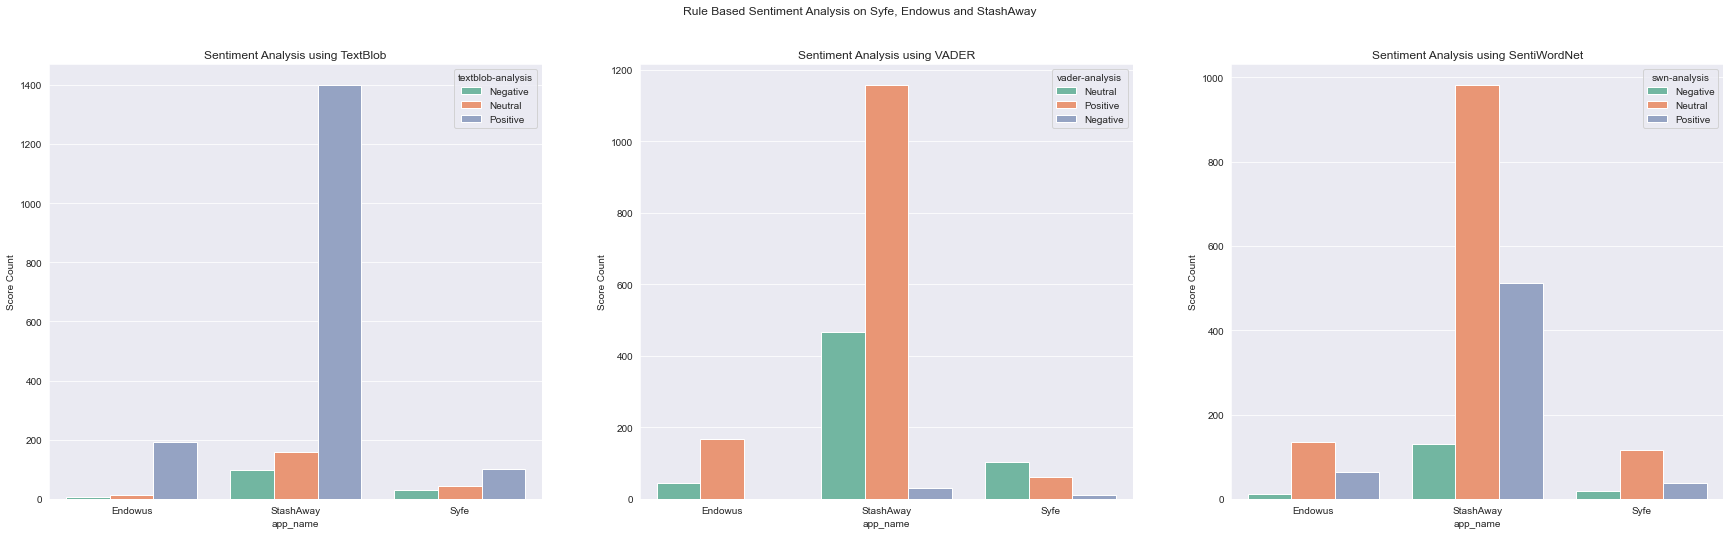

In [ ]:
sns.set_style( 'darkgrid' )
col = sns.color_palette("Set2")
fig, axes = plt.subplots(1,3,figsize=[30,8])
fig.suptitle('Rule Based Sentiment Analysis on Syfe, Endowus and StashAway')

## Plot 1
sns.barplot(ax=axes[0],data=tb_counts_df,x='app_name',y='count',hue='textblob-analysis', palette=col)
axes[0].set_title('Sentiment Analysis using TextBlob')
axes[0].set_ylabel('Score Count')

## Plot 2
sns.barplot(ax=axes[1],data=vd_counts_df,x='app_name',y='count',hue='vader-analysis', palette=col)
axes[1].set_title('Sentiment Analysis using VADER')
axes[1].set_ylabel('Score Count')

## Plot 3
sns.barplot(ax=axes[2],data=swn_counts_df,x='app_name',y='count',hue='swn-analysis', palette=col)
axes[2].set_title('Sentiment Analysis using SentiWordNet')
axes[2].set_ylabel('Score Count')

### Percentage Comparison

In [ ]:
# Convert sentiment results from series into dataframes
tb_grouped_df = tb_counts_df.groupby(['app_name',tb_counts_df['textblob-analysis']]).agg({'count':'sum'})
tb_percent_df = tb_grouped_df.groupby(level=0).apply(lambda x: 100*x/float(x.sum()))
tb_percent_df = pd.DataFrame(tb_percent_df).reset_index().rename(columns={'count':'perc_count'})

vd_grouped_df = vd_counts_df .groupby(['app_name',vd_counts_df['vader-analysis']]).agg({'count':'sum'})
vd_percent_df = vd_grouped_df.groupby(level=0).apply(lambda x: 100*x/float(x.sum()))
vd_percent_df = pd.DataFrame(vd_percent_df).reset_index().rename(columns={'count':'perc_count'})


swn_grouped_df = swn_counts_df .groupby(['app_name',swn_counts_df['swn-analysis']]).agg({'count':'sum'})
swn_percent_df = swn_grouped_df.groupby(level=0).apply(lambda x: 100*x/float(x.sum()))
swn_percent_df = pd.DataFrame(swn_percent_df).reset_index().rename(columns={'count':'perc_count'})


Text(0, 0.5, 'Score Count (%)')

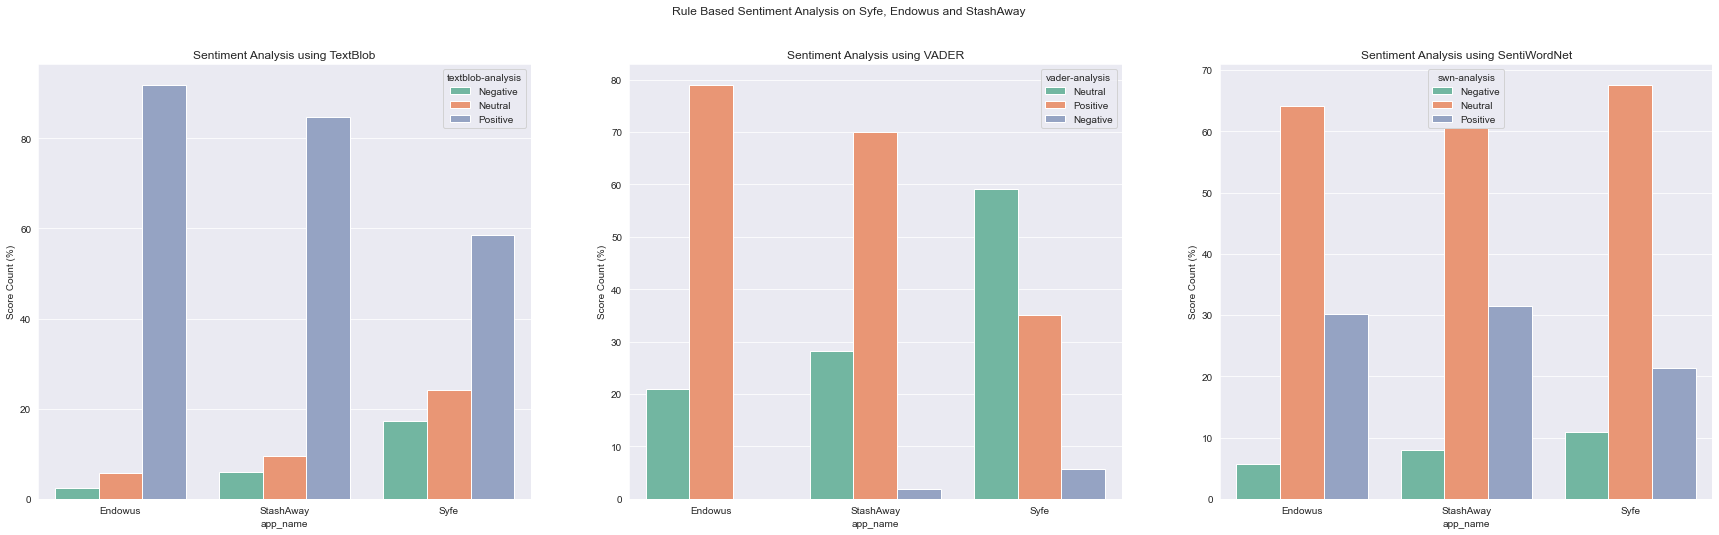

In [ ]:
sns.set_style( 'darkgrid' )
col = sns.color_palette("Set2")
fig1, axes1 = plt.subplots(1,3,figsize=[30,8])
fig1.suptitle('Rule Based Sentiment Analysis on Syfe, Endowus and StashAway')

## Plot 1
sns.barplot(ax=axes1[0],data=tb_percent_df,x='app_name',y='perc_count',hue='textblob-analysis', palette=col)
axes1[0].set_title('Sentiment Analysis using TextBlob')
axes1[0].set_ylabel('Score Count (%)')

## Plot 2
sns.barplot(ax=axes1[1],data=vd_percent_df,x='app_name',y='perc_count',hue='vader-analysis', palette=col)
axes1[1].set_title('Sentiment Analysis using VADER')
axes1[1].set_ylabel('Score Count (%)')

## Plot 3
sns.barplot(ax=axes1[2],data=swn_percent_df,x='app_name',y='perc_count',hue='swn-analysis', palette=col)
axes1[2].set_title('Sentiment Analysis using SentiWordNet')
axes1[2].set_ylabel('Score Count (%)')

# Key Takeaways
- Looking purely at their absolute numbers, Stashaway have the highest number of scores given that it has the largest number of app reviews. It's number of positive scores are overwhelmingly higher than negative scores. 
- Using SentiWordNet appears to depress the scores variance, with more scores distributed around neutral scores. Focusing on Stashaway, the number of positive  reviews decreased, and the number neutral scores shot up. 
- In terms of percentage score, Endowus leads in this aspect, with the highest percentage of positive reviews compared to StashAway and Syfe.
- All 3 roboadvisors have a higher percentage of positive scores, with a small percentage of negative reviews.
- Hierarchy of choice: Endowus or Stashaway > Syfe
- Anyone looking to choose any one of these roboadvisors can rest assured that all 3 apps have garnered good reviews from the users. 
